# Sensitivities through acados solver (optional)

In this exercise, we will use the acados solver to compute the sensitivities of the value functions.

In [1]:
import numpy as np
from casadi import Function
import scipy.linalg
import matplotlib.pyplot as plt

from acados_template import AcadosOcp, AcadosOcpSolver

from exercise11b_utils import LagrangeMultiplierExtractor, build_discrete_dynamics_functions, \
    build_cost_functions, build_constraint_functions, export_pendulum_ode_model, ERK4, update_parameters, \
        export_acados_ocp

Assume you have your OCP solver from `exercise07` available where the mass `M` is a parameter. Based on what you learned in the previous lecture, implement the function `state_value_function` below to return the state value for a given state. 

In [2]:

def state_value_function(acados_ocp_solver: AcadosOcpSolver, state: np.ndarray) -> float:
    """
    Evaluate the state-value function at the given state.

    Parameters:
        acados_ocp_solver: acados OCP solver object
        state: state

    Returns:
        state value
    """

    ######## YOUR CODE HERE #########
    pass
    #########################################

We discussed the connection between the sensitivities of the value functions to the Jacobian of the Lagrangian in the previous exercise. In the code below, modify `class LagrangeFunction` to compute the value of the Lagrangian at the computed solution in `def __call__`. You need to include the terms corresponding to the function for the dynamics equality constraint and the cost.

Hints:
- Functions for discrete dynamics and its Jacobian are already implemented.
- You get the multiplier corresponding to the dynamics equality constraint from the solver by calling `acados_ocp_solver.get(stage, "pi")`.

In [3]:
class LagrangeFunction(object):
    """
    Lagrange function for the OCP
    """

    lam_extractor: LagrangeMultiplierExtractor
    fun_f: Function  # Discrete dynamics
    fun_df_dp: Function  # Derivative of discrete dynamics with respect to parameters
    fun_l: Function  # Stage cost
    fun_m: Function  # Terminal cost
    fun_dl_dp: Function  # Derivative of stage cost with respect to parameters
    fun_dm_dp: Function  # Derivative of terminal cost with respect to parameters

    def __init__(self, acados_ocp_solver: AcadosOcpSolver):
        super().__init__()

        self.lam_extractor = LagrangeMultiplierExtractor(
            acados_ocp_solver.acados_ocp.constraints,
            acados_ocp_solver.acados_ocp.dims.N,
        )

        self.fun_f, self.fun_df_dp = build_discrete_dynamics_functions(acados_ocp_solver.acados_ocp)
        self.fun_l, self.fun_m, self.fun_dl_dp, self.fun_dm_dp = build_cost_functions(acados_ocp_solver.acados_ocp)
        _ = build_constraint_functions(acados_ocp_solver.acados_ocp)

    def __call__(self, acados_ocp_solver: AcadosOcpSolver, p: np.ndarray) -> np.float32:
        """
        Evaluate the Lagrange function at the current solution of the OCP.
        """

        res = 0.0

        constraints = acados_ocp_solver.acados_ocp.constraints

        # Initial condition equality constraint
        stage = 0
        res += self.lam_extractor(stage, "lbx_0", acados_ocp_solver.get(stage, "lam")) @ (
            getattr(constraints, "lbx_0") - acados_ocp_solver.get(stage, "x")
        )

        res += self.lam_extractor(stage, "ubx_0", acados_ocp_solver.get(stage, "lam")) @ (
            getattr(constraints, "ubx_0") - acados_ocp_solver.get(stage, "x")
        )

        # Inequality constraints at stage k
        if getattr(constraints, "lbx").size > 0:
            for stage in range(1, acados_ocp_solver.acados_ocp.dims.N):
                res += self.lam_extractor(stage, "lbx", acados_ocp_solver.get(stage, "lam")) @ (
                    getattr(constraints, "lbx") - acados_ocp_solver.get(stage, "x")
                )

        if getattr(constraints, "ubx").size > 0:
            for stage in range(1, acados_ocp_solver.acados_ocp.dims.N):
                res += self.lam_extractor(stage, "ubx", acados_ocp_solver.get(stage, "lam")) @ (
                    getattr(constraints, "ubx") - acados_ocp_solver.get(stage, "x")
                )

        if getattr(constraints, "lbu").size > 0:
            for stage in range(1, acados_ocp_solver.acados_ocp.dims.N):
                res += self.lam_extractor(stage, "lbu", acados_ocp_solver.get(stage, "lam")) @ (
                    getattr(constraints, "lbu") - acados_ocp_solver.get(stage, "u")
                )

        if getattr(constraints, "ubu").size > 0:
            for stage in range(1, acados_ocp_solver.acados_ocp.dims.N):
                res += self.lam_extractor(stage, "ubu", acados_ocp_solver.get(stage, "lam")) @ (
                    getattr(constraints, "ubu") - acados_ocp_solver.get(stage, "u")
                )

        # Terminal state inequality constraints
        stage = acados_ocp_solver.acados_ocp.dims.N
        if getattr(constraints, "lbx_e").size > 0:
            res += self.lam_extractor(stage, "lbx_e", acados_ocp_solver.get(stage, "lam")) @ (
                getattr(constraints, "lbx_e") - acados_ocp_solver.get(stage, "x")
            )

        if getattr(constraints, "ubx_e").size > 0:
            res += self.lam_extractor(stage, "ubx_e", acados_ocp_solver.get(stage, "lam")) @ (
                getattr(constraints, "ubx_e") - acados_ocp_solver.get(stage, "x")
            )



        ############### YOUR CODE HERE #############

        # Add term corresponding to dynamic equality constraint

        # Add term corresponding to the cost function

        ########################################

        return res

    def eval_f(self, x: np.ndarray, u: np.ndarray, p: np.ndarray) -> np.ndarray:
        """
        Evaluate the integrator at the current solution of the OCP.

        Parameters:
            x: state
            u: control
            p: parameters

        Returns:
            xf: integrated state
        """
        return self.fun_f(x=x, u=u, p=p)["xf"].full().flatten()

    def eval_df_dp(self, x: np.ndarray, u: np.ndarray, p: np.ndarray) -> np.ndarray:
        """
        Evaluate the gradient of the integrator with respect to the parameters at the current solution of the OCP.

        Parameters:
            x: state
            u: control
            p: parameters

        Returns:
            df_dp: gradient of the integrator with respect to the parameters
        """
        return self.fun_df_dp(x=x, u=u, p=p)["dxf_dp"].full().flatten()

    def eval_dL_dp(self, acados_ocp_solver: AcadosOcpSolver, p: np.ndarray) -> np.ndarray:
        """
        Evaluate the gradient of the Lagrange function with respect to the parameters at the current solution of the OCP.

        Parameters:
            acados_ocp_solver: acados OCP solver object with the current solution
            p: parameters

        Returns:
            dL_dp: gradient of the Lagrange function with respect to the parameters
        """

        ###### YOUR CODE HERE ####################
        pass
        ########################################

Now we test your implementations above in a test function below where we compare the sensitivities computed by acados to the sensitivities computed by finite differences. If your implementations are correct, the test should pass. Modify the function to compute $\nabla_\theta V_\theta(x)$ for a given state $x$ and parameter $p$. You can use `lagrange_function` to do that. If the test outputs 0, it passed.

built ERK4 for pendulum model with dT =  0.05
rm -f libacados_ocp_solver_pendulum.so
rm -f acados_solver_pendulum.o
cc -fPIC -std=c99   -O2 -I/home/dirk/software/acados/include -I/home/dirk/software/acados/include/acados -I/home/dirk/software/acados/include/blasfeo/include -I/home/dirk/software/acados/include/hpipm/include  -c -o acados_solver_pendulum.o acados_solver_pendulum.c
cc -fPIC -std=c99   -O2 -I/home/dirk/software/acados/include -I/home/dirk/software/acados/include/acados -I/home/dirk/software/acados/include/blasfeo/include -I/home/dirk/software/acados/include/hpipm/include  -c -o pendulum_model/pendulum_dyn_disc_phi_fun.o pendulum_model/pendulum_dyn_disc_phi_fun.c
cc -fPIC -std=c99   -O2 -I/home/dirk/software/acados/include -I/home/dirk/software/acados/include/acados -I/home/dirk/software/acados/include/blasfeo/include -I/home/dirk/software/acados/include/hpipm/include  -c -o pendulum_model/pendulum_dyn_disc_phi_fun_jac.o pendulum_model/pendulum_dyn_disc_phi_fun_jac.c
cc -sh

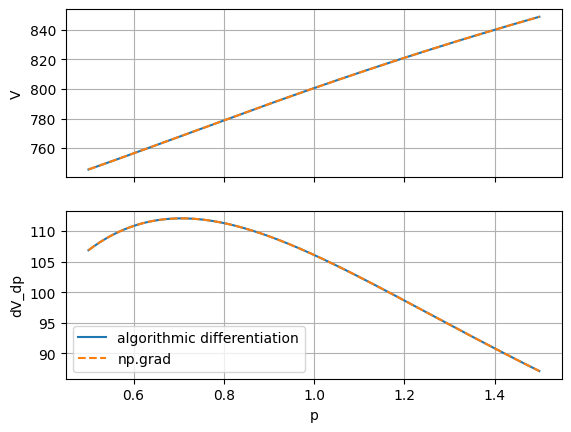

Test result:  0


In [4]:

def test_dV_dp(
    acados_ocp_solver: AcadosOcpSolver,
    x0: np.ndarray = np.array([0.5, 0.0, 0.0, 0.0]),
    p_test: np.ndarray = np.arange(0.5, 1.5, 0.001),
    plot=False,
):
    lagrange_function = LagrangeFunction(acados_ocp_solver)

    V = np.zeros(p_test.shape[0])
    dV_dp = np.zeros(p_test.shape[0])
    for i, p_i in enumerate(p_test):
        acados_ocp_solver = update_parameters(acados_ocp_solver=acados_ocp_solver, p=p_i)
        acados_ocp_solver.solve_for_x0(x0)
        V[i] = state_value_function(acados_ocp_solver=acados_ocp_solver, state=x0)

        ####### YOUR CODE HERE ################
        dV_dp[i] = ...
        #######################################

    dV_dp_grad = np.gradient(V, p_test)

    dp = p_test[1] - p_test[0]

    V_reconstructed = np.cumsum(dV_dp) * dp + V[0]
    constant = V[0] - V_reconstructed[0]
    V_reconstructed += constant

    if plot:
        _, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
        ax[0].plot(p_test, V)
        ax[0].plot(p_test, V_reconstructed, "--")
        ax[1].plot(p_test, dV_dp)
        ax[1].plot(p_test, dV_dp_grad, "--")
        ax[1].legend(["algorithmic differentiation", "np.grad"])
        ax[0].set_ylabel("V")
        ax[1].set_ylabel("dV_dp")
        ax[1].set_xlabel("p")
        ax[0].grid(True)
        ax[1].grid(True)

        plt.show()

    return int(not np.allclose(dV_dp, dV_dp_grad, rtol=1e-2, atol=1e-2))


p_test = np.arange(0.5, 1.5, 0.001)

x0 = np.array([0.0, np.pi / 2, 0.0, 0.0])

ocp = export_acados_ocp()

acados_ocp_solver = AcadosOcpSolver(ocp, json_file="acados_ocp.json")

print("Test result: ", test_dV_dp(acados_ocp_solver=acados_ocp_solver, x0=x0, p_test=p_test, plot=True))

## State-action value function and its sensitivity

We now want to find the state-action value function and its sensitivity with respect to the initial state $x_0$ and the initial action $u_0$. We will again use an AcadosOcpSolver object, and start from the same OCP as for the state value function.

In [5]:

def export_q_value_acados_ocp() -> AcadosOcp:
    """
    Define the acados OCP solver object.

    Parameters:
        ocp: acados OCP object

    Returns:
        acados_ocp_solver: acados OCP solver object
    """

    # create ocp object to formulate the OCP
    ocp = AcadosOcp()

    # set model
    model = export_pendulum_ode_model()

    Tf = 1.0
    N = 20
    dT = Tf / N

    ode = Function("ode", [model.x, model.u, model.p], [model.f_expl_expr])
    model.disc_dyn_expr = ERK4(ode, model.x, model.u, model.p, dT)
    print("built ERK4 for pendulum model with dT = ", dT)

    ###
    ocp.model = model

    nx = model.x.size()[0]
    nu = model.u.size()[0]
    ny = nx + nu
    ny_e = nx

    # set dimensions
    ocp.dims.N = N

    # set cost module
    ocp.cost.cost_type = "LINEAR_LS"
    ocp.cost.cost_type_e = "LINEAR_LS"

    Q = 2 * np.diag([1e3, 1e3, 1e-2, 1e-2])
    R = 2 * np.diag([1e-1])

    ocp.cost.W = scipy.linalg.block_diag(Q, R)

    ocp.cost.W_e = Q

    ocp.cost.Vx = np.zeros((ny, nx))
    ocp.cost.Vx[:nx, :nx] = np.eye(nx)

    Vu = np.zeros((ny, nu))
    Vu[4, 0] = 1.0
    ocp.cost.Vu = Vu

    ocp.cost.Vx_e = np.eye(nx)

    ocp.cost.yref = np.array((0.0, 0.0, 0.0, 0.0, 0.0))
    ocp.cost.yref_e = np.array((0.0, 0.0, 0.0, 0.0))

    # set constraints
    Fmax = 80
    x0 = np.array([0.5, 0.0, 0.0, 0.0])
    ocp.constraints.lbu = np.array([-Fmax])
    ocp.constraints.ubu = np.array([+Fmax])
    ocp.constraints.x0 = x0
    ocp.constraints.idxbu = np.array([0])
    
    ################################
    ocp.constraints.idxsbu = np.array([0])
    ocp.cost.zu = np.array([1e3])
    ocp.cost.zl = np.array([1e3])
    ocp.cost.Zl = np.array([1e3])
    ocp.cost.Zu = np.array([1e3])
    ################################

    ocp.solver_options.qp_solver = "PARTIAL_CONDENSING_HPIPM"
    ocp.solver_options.hessian_approx = "GAUSS_NEWTON"
    ocp.solver_options.integrator_type = "DISCRETE"
    ocp.solver_options.nlp_solver_type = "SQP"

    ocp.solver_options.qp_solver_cond_N = N

    ocp.solver_options.qp_solver_iter_max = 200

    # set prediction horizon
    ocp.solver_options.tf = Tf

    ocp.parameter_values = np.array([1.0])

    return ocp

Assume you created an AcadosOcpSolver based on your OCP. Use it in the function `state_action_value_function` below to compute the state-action value Q.

In [6]:

def state_action_value_function(
    acados_ocp_solver: AcadosOcpSolver,
    state: np.ndarray,
    action: np.ndarray
) -> float:
    """
    Evaluate the action-value function at the given state and action.

    Parameters:
        acados_ocp_solver: acados OCP solver object
        state: state
        a: action

    Returns:
        float: action-value function value
    """

    ######## Your code here ##########
    pass
    ########################################

Let's put it all together and test the function `state_action_value_function` similar to the test above.

built ERK4 for pendulum model with dT =  0.05
rm -f libacados_ocp_solver_pendulum.so
rm -f acados_solver_pendulum.o
cc -fPIC -std=c99   -O2 -I/home/dirk/software/acados/include -I/home/dirk/software/acados/include/acados -I/home/dirk/software/acados/include/blasfeo/include -I/home/dirk/software/acados/include/hpipm/include  -c -o acados_solver_pendulum.o acados_solver_pendulum.c
cc -fPIC -std=c99   -O2 -I/home/dirk/software/acados/include -I/home/dirk/software/acados/include/acados -I/home/dirk/software/acados/include/blasfeo/include -I/home/dirk/software/acados/include/hpipm/include  -c -o pendulum_model/pendulum_dyn_disc_phi_fun.o pendulum_model/pendulum_dyn_disc_phi_fun.c
cc -fPIC -std=c99   -O2 -I/home/dirk/software/acados/include -I/home/dirk/software/acados/include/acados -I/home/dirk/software/acados/include/blasfeo/include -I/home/dirk/software/acados/include/hpipm/include  -c -o pendulum_model/pendulum_dyn_disc_phi_fun_jac.o pendulum_model/pendulum_dyn_disc_phi_fun_jac.c
cc -sh

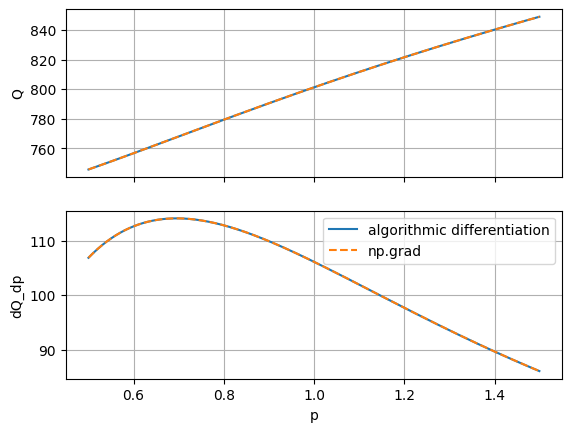

Test result:  0


In [7]:

def test_dQ_dp(
    acados_ocp_solver: AcadosOcpSolver,
    state: np.ndarray = np.array([0.5, 0.0, 0.0, 0.0]),
    action: np.ndarray = np.array([20.0]),
    p_test: np.ndarray = np.arange(0.5, 1.5, 0.001),
    plot: bool = False,
) -> int:
    """
    Test the derivative of the action-value function with respect to the parameters.

    Parameters:
        acados_ocp_solver: acados OCP solver object
        action: action value
        p_test: parameter values to test
        plot: plot the results

    Returns:
        int: 0 if test passed, 1 otherwise
    """

    # Define the Lagrange function
    lagrange_function = LagrangeFunction(acados_ocp_solver)

    # Evaluate the derivative of the action-value function with respect to the parameters
    Q = np.zeros(p_test.shape[0])
    dQ_dp = np.zeros(p_test.shape[0])
    for i, p_i in enumerate(p_test):
        acados_ocp_solver = update_parameters(acados_ocp_solver=acados_ocp_solver, p=p_i)
        u0 = acados_ocp_solver.solve_for_x0(state)

        Q[i] = state_action_value_function(
            acados_ocp_solver=acados_ocp_solver,
            state=state,
            action=u0,
        )

        
        #### YOUR CODE HERE ##################
        dQ_dp[i] = ...
        ######################################

    dQ_dp_grad = np.gradient(Q, p_test)

    dp = p_test[1] - p_test[0]

    Q_reconstructed = np.cumsum(dQ_dp) * dp + Q[0]
    constant = Q[0] - Q_reconstructed[0]
    Q_reconstructed += constant

    if plot:
        _, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
        ax[0].plot(p_test, Q)
        ax[0].plot(p_test, Q_reconstructed, "--")
        ax[1].plot(p_test, dQ_dp)
        ax[1].plot(p_test, dQ_dp_grad, "--")
        ax[1].legend(["algorithmic differentiation", "np.grad"])
        ax[0].set_ylabel("Q")
        ax[1].set_ylabel("dQ_dp")
        ax[1].set_xlabel("p")
        ax[0].grid(True)
        ax[1].grid(True)

        plt.show()

    return int(not np.allclose(dQ_dp, dQ_dp_grad, rtol=1e-1, atol=1e-1))

q_ocp = export_q_value_acados_ocp()

acados_ocp_solver = AcadosOcpSolver(q_ocp, json_file="acados_q_ocp.json")


p_test = np.arange(0.5, 1.5, 0.001)
x0 = np.array([0.0, np.pi / 2, 0.0, 0.0])
print("Test result: ", test_dQ_dp(acados_ocp_solver=acados_ocp_solver, state=x0, action=np.array([1.0]), p_test=p_test, plot=True))

If your solver failed due to constraints specific to bounds you set in `state_action_value_function`, you can try to relax that constraint. If the test outputs 0, it passed.